In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [3]:
train_path = glob("./cityscapes_data/train/*")
valid_path = glob("./cityscapes_data/val/*")

In [4]:
# fig,ax = plt.subplots(5,2,figsize=(10,30))
# for i in range(5):
#     img = plt.imread(train_path[i])
#     ax[i][0].imshow(img[:,:256])
#     ax[i][1].imshow(img[:,256:])

In [5]:
train_dataset = []
validation_dataset = []

In [6]:
class MyDataset(Dataset):

    def __init__(self, images_path, transform_img=None, transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):

        img = plt.imread(self.images_path[idx])
        image, label = img[:, : int(img.shape[1] / 2)], img[:, int(img.shape[1] / 2) :]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [7]:
mytransforms = transform.Compose(
    [
        transform.ToTensor(),
        transform.RandomHorizontalFlip(p=0.9),
    ]
)

In [8]:
# train dataset
traindata = MyDataset(train_path, mytransforms, mytransforms)
# val dataset
valdata = MyDataset(valid_path, mytransforms, mytransforms)

In [9]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata, batch_size)
vaild_loader = DataLoader(valdata, 1)

In [10]:
"""
    This is a helper function.
    This will help in ploting the masked got from the model.

"""


def show(img, output, label, denorm=False):
    img, output, label = img.cpu(), output.cpu(), label.cpu()
    fig, ax = plt.subplots(len(output), 3, figsize=(10, 10))

    for i in range(len(output)):
        if len(output) == 3:
            Img, Lab, act = img[i], output[i], label[i]
            Img, Lab, act = Img, Lab.detach().permute(1, 2, 0).numpy(), act
            ax[i][0].imshow(Img.permute(1, 2, 0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1, 2, 0))
        else:
            Img, Lab, act = img[i], output[i], label[i]
            Img, Lab, act = Img, Lab.detach().permute(1, 2, 0).numpy(), act
            ax[0].imshow(Img.permute(1, 2, 0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1, 2, 0))
    plt.show()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
print(device)

cuda


In [13]:
"""

    This Module representes the individual horizontal conv block layers in the Unet Model.
    Conv() -> BatchNorm() -> ReLU() -> Conv() -> ReLU()

"""


class Convblock(nn.Module):

    def __init__(self, input_channel, output_channel, kernal=3, stride=1, padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernal, stride, padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, kernal),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.convblock(x)
        return x

In [14]:
# Encoder -> BottelNeck => Decoder
class UNet(nn.Module):

    def __init__(self, input_channel, retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel, 32)
        self.conv2 = Convblock(32, 64)
        self.conv3 = Convblock(64, 128)
        self.conv4 = Convblock(128, 256)
        self.neck = nn.Conv2d(256, 512, 3, 1)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 3, 2, 0, 1)
        self.dconv4 = Convblock(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 0, 1)
        self.dconv3 = Convblock(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 3, 2, 0, 1)
        self.dconv2 = Convblock(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 0, 1)
        self.dconv1 = Convblock(64, 32)
        self.out = nn.Conv2d(32, 3, 1, 1)
        self.retain = retain

    def forward(self, x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1, kernel_size=2, stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2, kernel_size=2, stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3, kernel_size=2, stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4, kernel_size=2, stride=2)

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4, upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4, croped], 1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3, upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3, croped], 1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2, upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2, croped], 1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1, upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1, croped], 1))
        # Output Layer
        out = self.out(dconv1)

        if self.retain == True:
            out = F.interpolate(out, list(x.shape)[2:])

        return out

    def crop(self, input_tensor, target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _, _, H, W = target_tensor.shape
        return transform.CenterCrop([H, W])(input_tensor)

In [15]:
model = UNet(3).float().to(device)

In [16]:
lr = 0.01
epochs = 30

In [17]:
# Choosing the loss function to be Mean Square Error Loss
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

In [19]:
train_loader

In [20]:
'''
    Traning the Model.
# '''
# img , label  = train_loader
# optimizer.zero_grad()
# img = img.to(device)
# label = label.to(device)
# output = model(img)
# loss = lossfunc(output,label)
# loss.backward()
# optimizer.step()
# trainloss+=loss.item()
# show(img, output, label)

'\n    Traning the Model.\n# '

  0%|          | 0/744 [00:00<?, ?it/s]/home/voy/.conda/envs/chinaa312/lib/python3.12/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
100%|██████████| 744/744 [01:25<00:00,  8.73it/s]


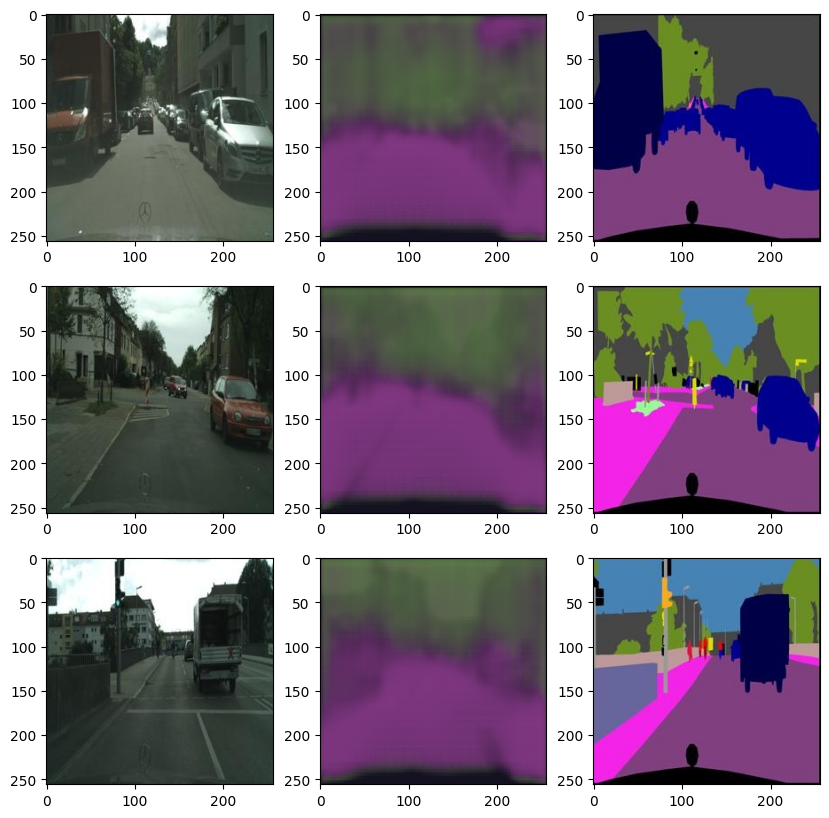

100%|██████████| 500/500 [00:05<00:00, 85.22it/s]


epoch : 0 ,train loss : 0.036467613179176565 ,valid loss : 0.030320746341720224 


100%|██████████| 500/500 [00:06<00:00, 79.66it/s]


epoch : 1 ,train loss : 0.02964828295823467 ,valid loss : 0.029343297738581894 


100%|██████████| 500/500 [00:06<00:00, 81.53it/s]


epoch : 2 ,train loss : 0.0271034640202459 ,valid loss : 0.02841674225591123 


 47%|████▋     | 348/744 [00:41<00:47,  8.30it/s]


KeyboardInterrupt: 

In [21]:
for i in range(epochs):
    
    trainloss = 0
    valloss = 0
    
    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    
    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))    
  
    for img,label in tqdm(vaild_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()
        
    val_loss.append(valloss/len(vaild_loader))  
    
    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

In [22]:
from torchsummary import summary

In [24]:
# Get a sample image and label from the dataset
image, label = traindata[0]

# Print the size of the image tensor
print("Input image size:", image.size())

Input image size: torch.Size([3, 256, 256])


In [26]:
summary(model, image.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 254, 254]           9,248
              ReLU-5         [-1, 32, 254, 254]               0
         Convblock-6         [-1, 32, 254, 254]               0
            Conv2d-7         [-1, 64, 127, 127]          18,496
       BatchNorm2d-8         [-1, 64, 127, 127]             128
              ReLU-9         [-1, 64, 127, 127]               0
           Conv2d-10         [-1, 64, 125, 125]          36,928
             ReLU-11         [-1, 64, 125, 125]               0
        Convblock-12         [-1, 64, 125, 125]               0
           Conv2d-13          [-1, 128, 62, 62]          73,856
      BatchNorm2d-14          [-1, 128,